# CNN Feature classifier trained with cropped images dataset from COCO motorcycles detector (BALANCED original dataset)

This is a CNN classifier using the cropped images dataset created with the COCO motorcycles detector. We have used here the BALANCED original data set (i.e. no bottom 6 cities; even number of places).

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tqdm import tqdm
import time
import shutil
import glob
import scipy
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
# WARNING: It is important that tf is version 2.10, otherwise CUDA is not supported on Windows!
print('Tensorflow version: ', tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9067291239636657803
xla_global_id: -1
]
Tensorflow version:  2.16.1


In [2]:
print(tf.test.is_gpu_available())# GPU 
physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


**Setup**

Dataset: TODO: PUT LINK TO DATASET

In [3]:
root_path = os.getcwd()

In [4]:
city_names = ['Bangkok', 
              'Barcelona',  
              'Boston',
              'Brussels',
              'Chicago',
              'Lisbon',
              'London',
              'Madrid',
              'Melbourne',
              'Miami',
              'Minneapolis',
              'Osaka',
              'Phoenix',
              'PRG',
              'PRS',
              'Rome',
              'TRT']

**Quick data exploration**

Find the average dimension of the images in the training set, to optimise the first layer of the classifier NN.

In [6]:
path_img_train = root_path + '\\Images\\Train\\'
widths = []
heights = []
for city_name in tqdm(city_names):
    city_path_train = path_img_train + "\\" + city_name
    #print(os.listdir(city_path_train))
    for img_path in os.listdir(city_path_train):
        im = cv2.imread(city_path_train + "\\" + img_path)
        h, w, _ = im.shape
        widths.append(w)
        heights.append(h)
av_width = sum(widths) / len(widths)
av_height = sum(heights) / len(heights)
print(av_width, av_height)

100%|██████████| 17/17 [02:35<00:00,  9.16s/it]

73.53327895484082 49.035514388685634


In [7]:
mean_width = int(av_width)
mean_height = int(av_height)

In [8]:
path_img_test = root_path + '\\Images\\Test\\'
count_test_files_by_city = []
path_img_train = root_path + '\\Images\\Train\\'
count_train_files_by_city = []
for city_name in tqdm(city_names):
    city_path_test = path_img_test + "\\" + city_name
    count_test_files_by_city.append([city_name, len(os.listdir(city_path_test))])
    city_path_train = path_img_train + "\\" + city_name
    count_train_files_by_city.append([city_name, len(os.listdir(city_path_train))])
total_count_test_files = sum([x[1] for x in count_test_files_by_city])
total_count_train_files = sum([x[1] for x in count_train_files_by_city])
train_proportions_by_city = [[x[0], x[1]/total_count_train_files] for x in count_train_files_by_city]
test_proportions_by_city = [[x[0], x[1]/total_count_test_files] for x in count_test_files_by_city]

100%|██████████| 17/17 [00:01<00:00, 14.44it/s]


In [9]:
print(f"The train files count (total = {total_count_train_files}) by city is")
sorted(count_train_files_by_city, key = lambda tuple: tuple[1], reverse = True)

The train files count (total = 293008) by city is


[['Chicago', 28684],
 ['Lisbon', 27800],
 ['London', 23021],
 ['Rome', 21896],
 ['PRS', 21813],
 ['Melbourne', 21791],
 ['Boston', 21726],
 ['Miami', 21492],
 ['Minneapolis', 17942],
 ['Brussels', 15964],
 ['Phoenix', 13923],
 ['PRG', 12934],
 ['Madrid', 11579],
 ['Bangkok', 11187],
 ['TRT', 8234],
 ['Barcelona', 6758],
 ['Osaka', 6264]]

In [10]:
print(f"The train proportions by city are")
sorted(train_proportions_by_city, key = lambda tuple: tuple[1], reverse = True)

The train proportions by city are


[['Chicago', 0.09789493802217004],
 ['Lisbon', 0.09487795555070169],
 ['London', 0.07856782067383826],
 ['Rome', 0.0747283350625239],
 ['PRS', 0.07444506634631136],
 ['Melbourne', 0.07436998307213455],
 ['Boston', 0.07414814612570306],
 ['Miami', 0.07334953311854966],
 ['Minneapolis', 0.061233822967291],
 ['Brussels', 0.0544831540435756],
 ['Phoenix', 0.0475174739256266],
 ['PRG', 0.04414213946376891],
 ['Madrid', 0.03951769234969694],
 ['Bangkok', 0.038179844918910064],
 ['TRT', 0.02810162179872222],
 ['Barcelona', 0.02306421667667777],
 ['Osaka', 0.021378255883798394]]

In [11]:
print(f"The test files count (total = {total_count_test_files}) by city is")
sorted(count_test_files_by_city, key = lambda tuple: tuple[1], reverse = True)

The test files count (total = 73160) by city is


[['Chicago', 6744],
 ['London', 6555],
 ['Lisbon', 6378],
 ['Boston', 6014],
 ['Melbourne', 5600],
 ['Miami', 5545],
 ['PRS', 5352],
 ['Rome', 5294],
 ['Minneapolis', 4424],
 ['Brussels', 3811],
 ['Phoenix', 3685],
 ['PRG', 3262],
 ['Madrid', 2918],
 ['Bangkok', 2509],
 ['TRT', 2065],
 ['Barcelona', 1552],
 ['Osaka', 1452]]

In [12]:
print(f"The test proportions by city are")
sorted(test_proportions_by_city, key = lambda tuple: tuple[1], reverse = True)

The test proportions by city are


[['Chicago', 0.09218151995626025],
 ['London', 0.0895981410606889],
 ['Lisbon', 0.08717878622197922],
 ['Boston', 0.08220338983050847],
 ['Melbourne', 0.07654455986878075],
 ['Miami', 0.07579278294149809],
 ['PRS', 0.07315472936030618],
 ['Rome', 0.0723619464188081],
 ['Minneapolis', 0.060470202296336796],
 ['Brussels', 0.05209130672498633],
 ['Phoenix', 0.05036905412793877],
 ['PRG', 0.04458720612356479],
 ['Madrid', 0.039885183160196826],
 ['Bangkok', 0.0342946965554948],
 ['TRT', 0.028225806451612902],
 ['Barcelona', 0.02121377802077638],
 ['Osaka', 0.019846910880262438]]

**Training the classifier**

In [13]:
path_img_train = root_path + '\\Images\\Train\\'
path_img_test = root_path + '\\Images\\Test\\'

In [14]:
batch_size = 8


img_height = mean_height 
img_width = mean_width

Create the generators:

In [15]:
# Here we use a built-in tensorflow function to load the training and validation datasets that can be then used by the neural network
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator()
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator()

train_ds = datagen_train.flow_from_directory(path_img_train,
                                             shuffle=True,
                                             seed=123, 
                                             target_size=(img_height, img_width), 
                                             batch_size=batch_size, 
                                             class_mode='sparse',
                                             classes = city_names)
val_ds = datagen_val.flow_from_directory(path_img_test,
                                         shuffle=True,
                                         seed=123, 
                                         target_size=(img_height, img_width), 
                                         batch_size=batch_size, 
                                         class_mode='sparse',
                                        classes = city_names)
class_names = train_ds.class_indices.keys()
print(class_names)
print(len(train_ds), len(val_ds))

Found 293008 images belonging to 17 classes.
Found 73160 images belonging to 17 classes.
dict_keys(['Bangkok', 'Barcelona', 'Boston', 'Brussels', 'Chicago', 'Lisbon', 'London', 'Madrid', 'Melbourne', 'Miami', 'Minneapolis', 'Osaka', 'Phoenix', 'PRG', 'PRS', 'Rome', 'TRT'])
36626 9145


# CNN Vanilla model

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\rapiduser\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 49, 73, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 49, 73, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 36, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 36, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       442,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,625 (1.71 MB)

 Trainable params: 448,625 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 4
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/4
    1/36626 ━━━━━━━━━━━━━━━━━━━━ 14:51:36 1s/step - accuracy: 0.1250 - loss: 2.8096

c:\Users\rapiduser\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36626/36626 ━━━━━━━━━━━━━━━━━━━━ 270s 7ms/step - accuracy: 0.1412 - loss: 2.6374 - val_accuracy: 0.1851 - val_loss: 2.5076
Epoch 2/4
36626/36626 ━━━━━━━━━━━━━━━━━━━━ 298s 8ms/step - accuracy: 0.2021 - loss: 2.4607 - val_accuracy: 0.1994 - val_loss: 2.4726
Epoch 3/4
36626/36626 ━━━━━━━━━━━━━━━━━━━━ 286s 8ms/step - accuracy: 0.2183 - loss: 2.4128 - val_accuracy: 0.2065 - val_loss: 2.4464
Epoch 4/4
36626/36626 ━━━━━━━━━━━━━━━━━━━━ 292s 8ms/step - accuracy: 0.2310 - loss: 2.3701 - val_accuracy: 0.2082 - val_loss: 2.4419


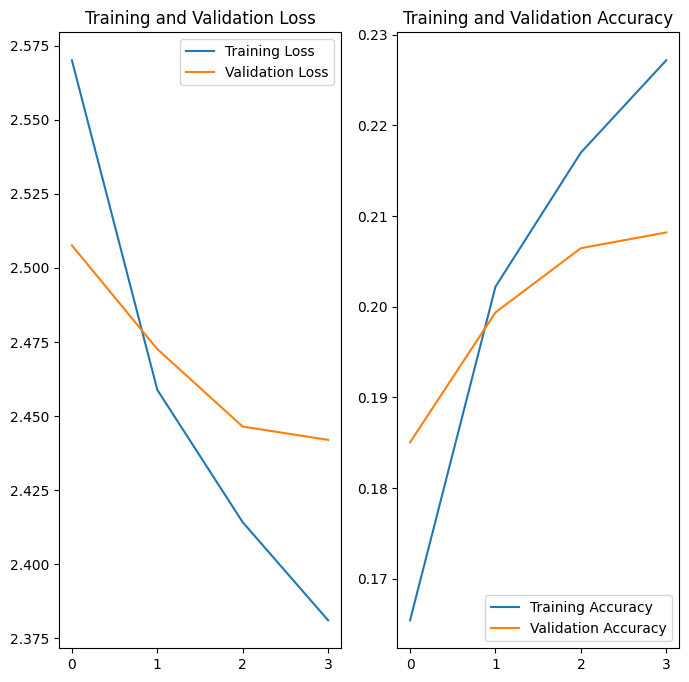

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


It looks like 6 epochs leads to overfitting. From the graphs, it looks like a good balance between underfit and overfit was reached at epoch 2 (x = 1 in the graphs above). So I'm going to retrain the model, but this time only with 2 epochs.

**2 epochs model**

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs = 2
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/2
36626/36626 ━━━━━━━━━━━━━━━━━━━━ 308s 8ms/step - accuracy: 0.1219 - loss: 2.6831 - val_accuracy: 0.1655 - val_loss: 2.5468
Epoch 2/2
17723/36626 ━━━━━━━━━━━━━━━━━━━━ 2:02 6ms/step - accuracy: 0.1714 - loss: 2.5285

KeyboardInterrupt: 

In [24]:
# Save the trained model_better
model.save('Vanilla_CNN_feature_classifier_5_epochs_COCO_cars_BALANCED_dataset_30052024.keras')

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



# Metrics and analysis of the results

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

We get the actual probabilities by applying a softmax.

In [35]:
probabilities = tf.nn.softmax(model.predict(val_ds))

9145/9145 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


In [36]:
predicted = probabilities.numpy()

Take the predicted label by applying argmax to the probabilities, for each prediction (i.e. for each image in val set).

In [37]:
pred_values = [np.argmax(p) for p in predicted]
len(pred_values)

73160

In [38]:
true_values = val_ds.classes.tolist()
len(true_values)

73160

**Baseline to beat:**

The naive baseline is the one that always predicts cities in order of frequencies of the data. (So, if we are just considering the top prediction, it will predict the city with the most data; if we are considering the top 2 prediction, it will predict the cities with the most and second-most data (in order), etc).

In [39]:
sorted_proportions_train = sorted(train_proportions_by_city, key = lambda tuple: tuple[1], reverse = True)
print(sorted_proportions_train)
def topn(sorted_proportions_train, n):
    sum_props = 0
    for i in range(n):
        sum_props = sum_props + sorted_proportions_train[i][1]
    return sum_props
print()
print(" Baselines to beat (training):")
print("Top 1 combined: ", topn(sorted_proportions_train, 1))

print()
print(" What we got (training):")
print("Top 1 combined: ", acc[-1])

print()

[['Chicago', 0.09789493802217004], ['Lisbon', 0.09487795555070169], ['London', 0.07856782067383826], ['Rome', 0.0747283350625239], ['PRS', 0.07444506634631136], ['Melbourne', 0.07436998307213455], ['Boston', 0.07414814612570306], ['Miami', 0.07334953311854966], ['Minneapolis', 0.061233822967291], ['Brussels', 0.0544831540435756], ['Phoenix', 0.0475174739256266], ['PRG', 0.04414213946376891], ['Madrid', 0.03951769234969694], ['Bangkok', 0.038179844918910064], ['TRT', 0.02810162179872222], ['Barcelona', 0.02306421667667777], ['Osaka', 0.021378255883798394]]

 Baselines to beat (training):
Top 1 combined:  0.09789493802217004

 What we got (training):
Top 1 combined:  0.2271883338689804



In [40]:
sorted_proportions_val = sorted(test_proportions_by_city, key = lambda tuple: tuple[1], reverse = True)
print(sorted_proportions_val)
print()
print(" Baselines to beat (validation):")
print("Top 1 combined: ", topn(sorted_proportions_val, 1))

print()
print(" What we got (validation):")
print("Top 1 combined: ", val_acc[-1])

print()

[['Chicago', 0.09218151995626025], ['London', 0.0895981410606889], ['Lisbon', 0.08717878622197922], ['Boston', 0.08220338983050847], ['Melbourne', 0.07654455986878075], ['Miami', 0.07579278294149809], ['PRS', 0.07315472936030618], ['Rome', 0.0723619464188081], ['Minneapolis', 0.060470202296336796], ['Brussels', 0.05209130672498633], ['Phoenix', 0.05036905412793877], ['PRG', 0.04458720612356479], ['Madrid', 0.039885183160196826], ['Bangkok', 0.0342946965554948], ['TRT', 0.028225806451612902], ['Barcelona', 0.02121377802077638], ['Osaka', 0.019846910880262438]]

 Baselines to beat (validation):
Top 1 combined:  0.09218151995626025

 What we got (validation):
Top 1 combined:  0.20820119976997375



**NOTE**

I'm not sure if the baseline to beat is the training one or the val one, and similarly if we should use the accuracy that we got in the training or in the validation against the baseline. In any case, if we take as the baseline the max of the baselines of train and val, and for what we got the min of the accuracies for train and val, we get:

In [41]:
# Worst cases
print(" Highest baselines to beat:")
print("Top 1 combined: ", max(topn(sorted_proportions_val, 1), topn(sorted_proportions_train, 1)))

print()
print(" Min accuracy we got:")
print("Top 1 combined: ", min(acc[-1], val_acc[-1]))

print()

 Highest baselines to beat:
Top 1 combined:  0.09789493802217004

 Min accuracy we got:
Top 1 combined:  0.20820119976997375



**Confusion matrices**

Text(0.5, 0.98, 'Confusion matrix for validation set (Top 1)')

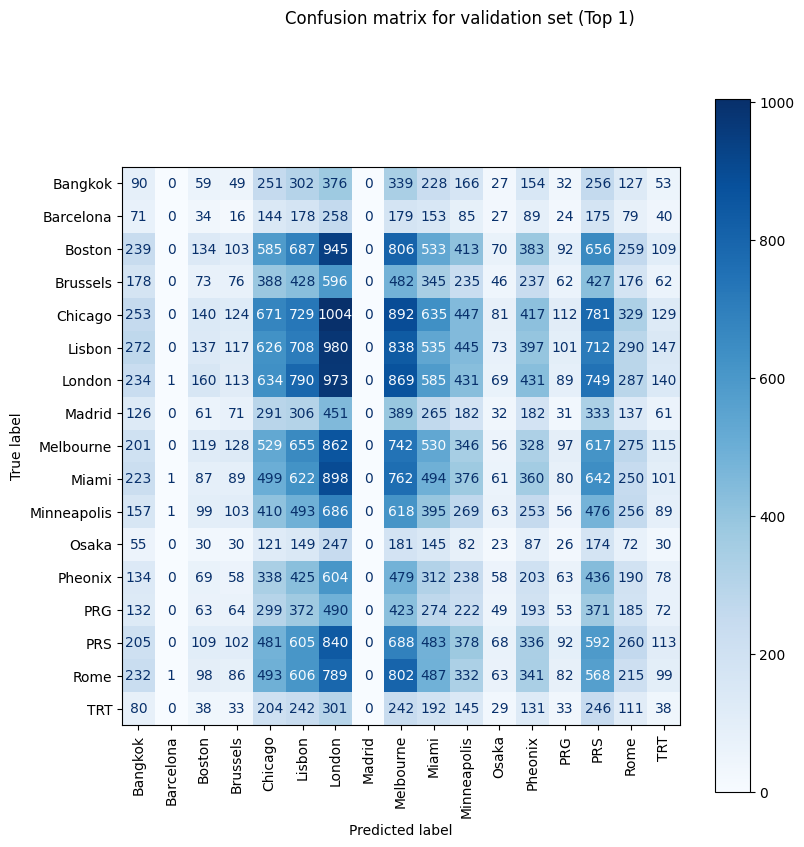

In [45]:
# Since in the valuation set there were no images for Miami or Phoenix, we need to remove them from labels (otherwise we get an error when labelling the confusion matrix)
labels = ['Bangkok', 'Barcelona', 'Boston', 'Brussels', 'Chicago', 'Lisbon', 'London', 'Madrid', 'Melbourne','Miami', 'Minneapolis', 'Osaka','Pheonix', 'PRG', 'PRS', 'Rome', 'TRT']
disp = ConfusionMatrixDisplay.from_predictions(true_values, pred_values,                                  
                                              display_labels=labels, 
                                              cmap=plt.cm.Blues, xticks_rotation=90
                                              ) 

fig = disp.figure_
fig.set_figwidth(9)
fig.set_figheight(9) 
fig.suptitle('Confusion matrix for validation set (Top 1)')